In [1]:
# Expand the view to scale with window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<h1 align="center">
ELMS1a
</h1>
<h2 align="center">
One Dimensional Diffusion Equation
</h2>
<h3 align="center">
By Francis J. Poulin, Adam Morgan and Ben Storer
</h3>

## Model Equations ##
The one-dimensional (1D) diffusion equation with variable Diffusivity $K(x)$ is
$$
\frac{\partial u}{\partial t} = \frac{\partial}{\partial {x}} \left(K(x)\frac{\partial u}{\partial x}\right).
$$
This is a **Parabolic PDE** of the parabolic type with 
\begin{align*}
\rho(x) &= 1,\\
p(x) &= K(x), \\ 
q(x) &= 0.
\end{align*}

We have the option to impose two sets of boundary conditions and one initial condition.

### Dirichlet: ###
$$
u(0,t) = 0,
\quad \mbox{ and } \quad
u(L_{x},t) = 0.
$$

### Neumann: ###
$$
\frac{\partial u}{\partial x}(0,t) = 0,
\quad \mbox{ and } \quad
\frac{\partial u}{\partial x}(L_{x},t) = 0.
$$

### Initial Condition ###
$$
u(x,0) = f(x).
$$

## Weak Form ##

In this tutorial we look at numerical solutions to the non-uniform diffusion equation, as written above.   Instead of discretizing this PDE and solving it directly, we instead form what is called a weak form.  This allows us to use a **Finite Element Method** (FE).  This method is perhaps more complicated than say the **Finite Difference** (FD) Method, but one of the advantages is that it allows us to use more complex geometries.  This is not something we see in 1D but we will better appreciate in 2D.

Since the PDE involves both spatial and temporal derivatives, we must find a way to approximate each. Our approach is to use a FD method in time (2nd order Crank-Nickolson) and a FE method in space (1st order).

#### Temporal Discretization ####

If we define $u_n(x) = u(x, t_n)$ then our time-stepping scheme is
$$
u^{n+1}  = u^n + \Delta t
\left[ \frac{\partial}{\partial {x}} \left(K(x)\frac{\partial}{\partial x}\left( \frac{u^{n+1} + u^n}{2} \right) \right)\right]
$$

#### Spatial Approximation ####

Next, we obtain the weak form of this equation by multiplying it by a test function $v$ to obtain the new solution $u^*$ in terms of the known solution $u^n$.
\begin{align*}
\int v u^* \, dx  
& = \int v u^n \, dx + \Delta t
\int v \left[ \frac{\partial}{\partial {x}} \left(K(x)\frac{\partial}{\partial x}\left( \frac{u^* + u^n}{2} \right) \right)\right] \, dx, \\
\int v u^* \, dx & = \int v u^n \, dx +  \Delta t \left[ K(x) v \frac{\partial}{\partial x}\left( \frac{u^* + u^n}{2} \right) \right]_0^{L_x}
- \Delta t \int \frac{\partial v}{\partial {x}} \left(K(x)\frac{\partial}{\partial x}\left( \frac{u^* + u^n}{2} \right) \right) \, dx.
\end{align*}
If we demand, as it the norm in finite element analysis, that the test function $v$ vanishes on the boundary, then
\begin{align*}
\int v u^*  + \frac{\Delta t}{2}  K(x) \frac{\partial v}{\partial {x}} \frac{\partial u^*}{\partial x} \, dx & =  \int v u^n  
- \frac{\Delta t}{2}  K(x) \frac{\partial v}{\partial {x}}\frac{\partial u^n}{\partial x} \, dx.
\end{align*}
The left hand side is a bilinear form, which we denote with $a(u^{*},v)$. The right hand side is a linear form, which we denote with $L(v)$. In this more compact notation, the weak form of the PDE at each time step becomes this: find $u^{*}$ such that the equation
\begin{align*}
a(u^{*},v) & = L(v)
\end{align*}
is satisfied for all differentiable functions $v$ vanishing on the boundary. At each time step we know the solution $u^n$. Then, we solve the above linear system for the new solution, $u^*$, and that is our $u^{n+1}$.

# Numerical Solution#

Below we go through each step of the numerical method to solve the above weak form.

#### Import Libraries

In [2]:
import firedrake as fdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean
from IPython.display import HTML
import sys

#### Specify parameters
 
1. <span style="color:red"> Bdry to go between Dirichlet and Neumann boundary conditions.</span>
2. You can change the final time, T, if you want the solution to last for longer.
3. You can change the length of the domain by modifying Lx. 
4. If you make the diffusion very strong then you might have to change the time step dt.   

In [3]:
T  = 2.0          # Final time
dt = 0.02         # Time step 
Nt = np.int(T/dt) # Number of time steps
Dt = fdr.Constant(dt)

Bdry = 'Dirichlet'
#Bdry = 'Neumann'

Lx = 6.0          # Length of domain
Nx = 400          # Number of elements

deg  = 2          # Order of approximation

#### Create the grid

In [4]:
# Time
tt = np.linspace(0., T, Nt)

# Space
mesh  = fdr.IntervalMesh(Nx, Lx)
x     = fdr.SpatialCoordinate(mesh)
xplot = np.linspace(0, Lx, Nx)

# Define Function Space
V = fdr.FunctionSpace(mesh, "CG", deg)         # Corresponds to  P_{deg}\Lambda^{0}(mathcal{T})

# Translate grid as a vector
xdata = fdr.interpolate(fdr.Expression("x[0]"),V).vector().array()[1:]

#### Set the boundary conditions

In [5]:
if Bdry == 'Dirichlet':
    
    #Remark: The DirichletBC command needs three arguments: 
    # function space, the value and which boundary endpoint 
    # Note: ("1" for left and "2" for right)    
    
    bcLeft  = fdr.DirichletBC(V, fdr.Constant(0.0), 1)
    bcRight = fdr.DirichletBC(V, fdr.Constant(0.0), 2)

    bcs = [bcLeft, bcRight]
    #bcs = [bcLeft]
    
elif Bdry == 'Neumann':

    bcs = []
    
else:

    print('Must select Dirichlet or Neumann boundary conditions')
    sys.exit()

#### Provide the diffusivity function $K(x)$


<span style="color:red"> By setting Opt you can have different diffusivities.</span>

Opt1: $ 1 + \exp\left( -5\left(x-\frac{Lx}{2}\right)^2 \right) $

Opt2: $ 1 + 2\left(\frac{x}{Lx} - 0.5\right)$

Opt3: $1 + \tanh\left[10 \cdot \left(\frac{x}{Lx} - \frac{1}{2}\right)\right] $

Opt4: $1 + 0.5\sin\left[ 2 \pi \left( x - \frac{Lx}{2}\right) / \frac{Lx}{2} \right]$

In [6]:
K = fdr.Function(V)

Opt = 0
if Opt==0: 
    K.interpolate(fdr.Expression(" 1 + 0*x[0]", Lx=Lx));    
elif Opt==1:
    K.interpolate(fdr.Expression(" 1 + exp(-5*pow(x[0]-Lx/2.,2))", Lx=Lx));
elif Opt==2:
    K.interpolate(fdr.Expression(" 1 + (x[0]-Lx/2)/Lx*2", Lx=Lx));
elif Opt==3:
    K.interpolate(fdr.Expression(" 1 + 0.9*tanh((x[0] - Lx/2)/(Lx/10))", Lx=Lx));
elif Opt==4:
    K.interpolate(fdr.Expression(" 1 + 0.9*sin(2*pi*(x[0] - Lx/2)/(Lx/2))", Lx=Lx));
else:
    printf("Must choose a valid option to set diffusitivity")
    sys.exit()

#### Plot Diffusivity 

Note that here we are using the firedrake-specific plotting features,
since we are plotting a Firedrake object. Under the hood it is still using
matplotlib, but it is tucked away.

/opt/firedrake/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

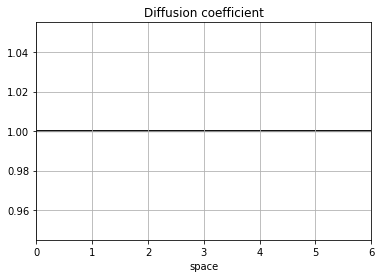

In [7]:
plt.figure()
fdr.plot(K)
plt.title('Diffusion coefficient')
plt.xlim([0, Lx])
plt.xlabel('space')
plt.grid('on')
plt.show()

#### Specify initial conditions

<span style="color:red"> You can change the initial conditions by uncommenting the first u0 and then commenting the second.  If you wanted to try something else you can ask and maybe I can help.</span>

In [8]:
# Define solutions
u0 = fdr.Function(V)    
u1 = fdr.Function(V)    

# Pick initial conditions
u0.interpolate(fdr.Expression("exp(-9*pow(x[0]-Lx/2.,2))", Lx=Lx));

# Constant: interesting with Dirichlet BCs
#u0.interpolate(fdr.Expression("1.0"));

#### Plot the inital conditions

/opt/firedrake/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

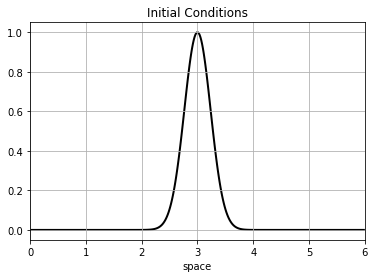

In [9]:
plt.figure()
fdr.plot(u0)
plt.title('Initial Conditions')
plt.xlim([0, Lx])
plt.xlabel('space')
plt.grid('on')
plt.show()

In [10]:
# Define functions to build weak form
v = fdr.TestFunction(V)
u = fdr.TrialFunction(V)
    
# Define weak form
# "a" is a bilinear form: a(u,v)
# "L" is a linear form:   L(v)
a = (v*u  + 0.5*K*Dt*( u.dx(0)*v.dx(0)))*fdr.dx
L = (v*u1 - 0.5*K*Dt*(u1.dx(0)*v.dx(0)))*fdr.dx  

In [11]:
# Define linear problem to solve at every time-step

problem = fdr.LinearVariationalProblem(a, L, u0, bcs=bcs)

params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}

#solver = fdr.LinearVariationalSolver(problem)
solver = fdr.LinearVariationalSolver(problem, solver_parameters=params)

#### Create arrays to store the solution

In [12]:
usoln      = np.zeros((Nt,Nx))
usoln[0,:] = u0.at(xplot, tolerance=1e-12)

mass = np.zeros(Nt)
mass[0] = fdr.assemble(u0*fdr.dx)

In [13]:
#### Loop over the time-steps, storing the solution as we go

In [14]:
for cnt in range(1,Nt):
    
    t = cnt*dt
    
    u1.assign(u0)
    solver.solve()
    
    mass[cnt] = fdr.assemble(u1*fdr.dx)
    
    usoln[cnt,:] = u1.at(xplot, tolerance=1e-12)

#### Plot mass and relative change

Note that in the case of Dirichlet boundary conditions, we do not expect mass/energy conservation. To see this, consider the long-term behaviour of the system.

/opt/firedrake/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


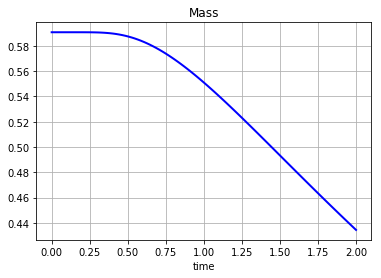

In [15]:
plt.figure()

plt.plot(tt, mass, 'b', lw=2, label='mass')
plt.xlabel('time')
plt.title('Mass')
plt.grid('on')

plt.show()

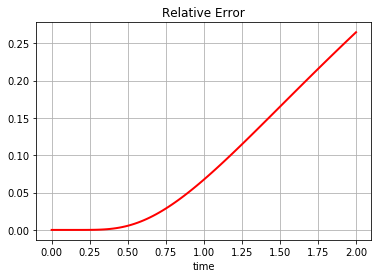

In [16]:
# Compute relative change
relerror = (mass[0] - mass)/mass[0]

plt.figure()

plt.plot(tt, relerror, 'r', lw=2, label='relative error')
plt.xlabel('time')
plt.title('Relative Error')
plt.grid('on')

plt.show()

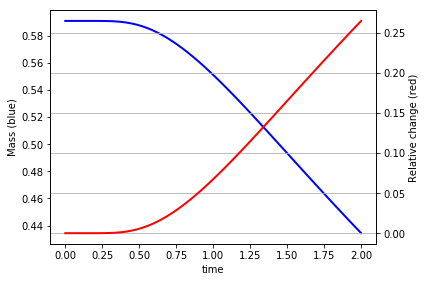

In [17]:
# Create figure and two y-axes
plt.figure()
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot the mass and relative change on the two axes
ax1.plot(tt, mass,     'b', lw=2, label='mass')
ax2.plot(tt, relerror, 'r', lw=2, label='relative error')

# Specify axis labels
ax1.set_xlabel('time')
ax1.set_ylabel('Mass (blue)')
ax2.set_ylabel('Relative change (red)')

# Add a grid
plt.grid('on')

# Fix some layout stuff
plt.tight_layout(True)

# Add legend
#plt.legend(loc='best')

# Not strictly necessary in iPython
plt.show()

#### Plot the evolution of the system

<span style="color:red"> You can uncomment the last line if you wave to save the figure to a file.  This is something you can also do for other still iamges.</span>

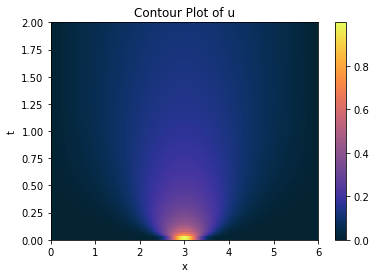

In [18]:
plt.figure()
plt.pcolor(xplot, tt, usoln, cmap = cmocean.cm.thermal)
plt.xlabel("x")
plt.ylabel("t")
plt.title("Contour Plot of u")
plt.colorbar()
plt.show()

#If you want to explort a figure to include in your writeup comment out the above line and uncomment the line below.
#plt.savefig('tmp.png')

### Create animations

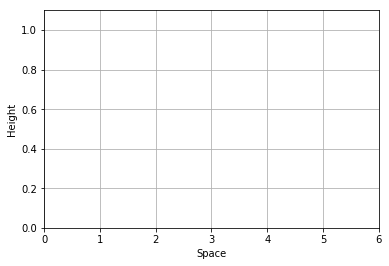

In [19]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 6.0), ylim=(0.0, 1.1))
ax.grid('on')
ax.set_xlabel('Space')
ax.set_ylabel('Height')
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    #line.grid('on')
    return line,

# animation function.  This is called sequentially
def animate(i):
    line.set_data(xplot, usoln[i,:])
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt, interval=20, blit=True)

In [20]:
HTML(anim.to_html5_video())

In [21]:
anim.save('simple_diffusion_VarConductivity.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [22]:
#!ls -al

In [23]:
# perhaps .local or .ipynb_checkpoints is causing issue

In [24]:
#!mv .local .local_old